[PROTECTED$11$](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/streaming-interruption.ipynb) [PROTECTED$12$](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239464-lesson-1-streaming)



# 流式传输（Streaming）

## 评论（Review）

In module 2, covered a few ways to customize graph state and memory.
 
We built up to a Chatbot with external memory that can sustain long-running conversations. 

在第2模块中，我们介绍了几种自定义图状态和内存的方法。

我们逐步构建了一个带有外部存储器的聊天机器人，它可以维持长时间的对话。

## 目标（Goals）

This module will dive into `human-in-the-loop`, which builds on memory and allows users to interact directly with graphs in various ways. 

本模块将深入探讨 `human-in-the-loop`，它基于内存构建，并允许用户以多种方式直接与图形交互。

To set the stage for `human-in-the-loop`, we'll first dive into streaming, which provides several ways to visualize graph output (e.g., node state or chat model tokens) over the course of execution.

为了为 `human-in-the-loop` 做铺垫，我们将首先深入探讨流式处理，它提供了多种方法来在执行过程中可视化图输出（例如，节点状态或聊天模型令牌）。



In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk

## 流式传输（Streaming）

LangGraph is built with [first class support for streaming](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming).

LangGraph 是使用 [first class support for streaming](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming) 构建的。

Let's set up our Chatbot from Module 2, and show various way to stream outputs from the graph during execution. 

让我们从第2模块设置聊天机器人，并展示在执行过程中从图中流式传输输出的各种方法。



In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

Note that we use `RunnableConfig` with `call_model` to enable token-wise streaming. This is [only needed with python < 3.11](https://langchain-ai.github.io/langgraph/how-tos/streaming-tokens/). We include in case you are running this notebook in CoLab, which will use python 3.x. 

请注意，我们使用 `RunnableConfig` 与 `call_model` 来启用按令牌流式传输。这是 [only needed with python < 3.11](https://langchain-ai.github.io/langgraph/how-tos/streaming-tokens/)。我们将其包含在内，以防您在 CoLab 中运行此笔记本，它将使用 python 3.x。



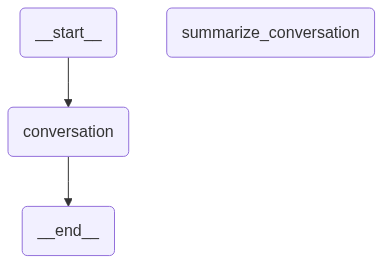

In [4]:
from IPython.display import Image, display

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

# LLM模型
model = ChatOpenAI(
    model="qwen-plus-2025-04-28",
    api_key="sk-ba2dda3817f145d7af141fdf32e31d90",
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1"
)

# 状态
class State(MessagesState):
    summary: str

# 定义调用模型的逻辑
def call_model(state: State, config: RunnableConfig):
    
    # 获取已存在的摘要
    summary = state.get("summary", "")

    # 如果有摘要，则添加它
    if summary:
        
        # 将摘要添加到系统消息中
        system_message = f"这是先前对话的摘要: {summary}"

        # 将摘要附加到任何较新的消息之前
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages, config)
    return {"messages": response}

def summarize_conversation(state: State):
    
    # 首先，我们获取任何已有的摘要
    summary = state.get("summary", "")

    # 创建我们的摘要提示
    if summary:
        
        # 摘要已存在
        summary_message = (
            f"这是迄今为止的对话摘要: {summary}\n\n"
            "请结合以上新消息扩展此摘要:"
        )
        
    else:
        summary_message = "为以上对话创建一个摘要:"

    # 将提示添加到我们的历史记录中
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # 删除除了最近2条之外的所有消息
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# 决定是结束还是总结对话
def should_continue(state: State):
    
    """返回下一个要执行的节点。"""
    
    messages = state["messages"]
    
    # 如果消息超过六条，我们就总结对话
    if len(messages) > 6:
        return "summarize_conversation"
    
    # 否则我们就可以结束了
    return END

# 定义一个新的图
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# 将入口点设置为 conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# 编译
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

### 流式传输完整状态（Streaming full state）

Now, let's talk about ways to [stream our graph state](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming).

现在，让我们来谈谈 [流式传输我们的图状态](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming) 的方法。

`.stream` and `.astream` are sync and async methods for streaming back results. 
 
LangGraph supports a few [different streaming modes](https://langchain-ai.github.io/langgraph/how-tos/stream-values/) for [graph state](https://langchain-ai.github.io/langgraph/how-tos/stream-values/):
 
* `values`: This streams the full state of the graph after each node is called.
* `updates`: This streams updates to the state of the graph after each node is called.

`.stream` 和 `.astream` 是用于流式返回结果的同步和异步方法。

LangGraph 支持几种 [different streaming modes](https://langchain-ai.github.io/langgraph/how-tos/stream-values/) 用于 [graph state](https://langchain-ai.github.io/langgraph/how-tos/stream-values/)：

*`values`：这将在每个节点被调用后流式传输图的完整状态。* `updates`：这将在每个节点被调用后流式传输图的状态更新。

![values_vs_updates.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbaf892d24625a201744e5_streaming1.png)

Let's look at `stream_mode="updates"`.

让我们来看一下 `stream_mode="updates"`。

Because we stream with `updates`, we only see updates to the state after node in the graph is run.

因为我们使用 `updates` 进行流式传输，所以只有在图中的节点运行后，我们才能看到状态的更新。

Each `chunk` is a dict with `node_name` as the key and the updated state as the value.

每个 `chunk` 是一个字典，以 `node_name` 为键，更新后的状态为值。



In [7]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="你好我是zxj")]}, config, stream_mode="updates"):
    print(chunk)

{'conversation': {'messages': AIMessage(content='你好，zxj！很高兴认识你～有什么我可以帮你的吗？😊', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 576, 'total_tokens': 592, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'qwen-plus-2025-04-28', 'system_fingerprint': None, 'id': 'chatcmpl-891471ae-2fe8-9b3d-b5f7-f4fcd55a4e16', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--f36409f3-af43-4e9b-8a46-39646ad7c106-0', usage_metadata={'input_tokens': 576, 'output_tokens': 16, 'total_tokens': 592, 'input_token_details': {}, 'output_token_details': {}})}}


Let's now just print the state update.

现在我们直接打印状态更新。



In [9]:
# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="你好我是zxj")]}, config, stream_mode="updates"):
    chunk['conversation']["messages"].pretty_print()

================================== Ai Message ==================================

你好呀，zxj！再次见到你真高兴～😊 有什么我可以帮忙的吗？


Now, we can see `stream_mode="values"`.

现在，我们可以看到 `stream_mode="values"`.

This is the `full state` of the graph after the `conversation` node is called.

这是在 `conversation` 节点被调用后，图的 `full state`。



In [10]:
# Start conversation, again
config = {"configurable": {"thread_id": "2"}}

# Start conversation
input_message = HumanMessage(content="你好我是zxj")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

================================ Human Message =================================

你好我是zxj
---------------------------------------------------------------------------
================================ Human Message =================================

你好我是zxj
================================== Ai Message ==================================

你好，zxj！有什么我可以帮你的吗？😊
---------------------------------------------------------------------------


### 流式传输令牌（Streaming tokens）

We often want to stream more than graph state.

我们通常希望传输的内容不仅仅是图形状态。

In particular, with chat model calls it is common to stream the tokens as they are generated.

特别是，对于聊天模型调用，通常会在生成令牌的同时以流式传输的方式处理这些令牌。

We can do this [using the PROTECTED$11$ method](https://langchain-ai.github.io/langgraph/how-tos/streaming-from-final-node/#stream-outputs-from-the-final-node), which streams back events as they happen inside nodes!

我们可以这样做 [using the PROTECTED$11$ method](https://langchain-ai.github.io/langgraph/how-tos/streaming-from-final-node/#stream-outputs-from-the-final-node)，它会在节点内部事件发生时实时回传事件！

Each event is a dict with a few keys:
 
* `event`: This is the type of event that is being emitted. 
* `name`: This is the name of event.
* `data`: This is the data associated with the event.
* `metadata`: Contains`langgraph_node`, the node emitting the event.

每个事件是一个包含几个键的字典：

*`event`：这是正在发出的事件的类型。* `name`：这是事件的名称。
*`data`：这是与事件相关联的数据。* `metadata`：包含 `langgraph_node`，即发出事件的节点。

Let's have a look.

让我们来看一下。



In [11]:
config = {"configurable": {"thread_id": "3"}}
input_message = HumanMessage(content="lol是什么")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    print(f"Node: {event['metadata'].get('langgraph_node','')}. Type: {event['event']}. Name: {event['name']}")

Node: . Type: on_chain_start. Name: LangGraph
Node: conversation. Type: on_chain_start. Name: conversation
Node: conversation. Type: on_chat_model_start. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. N

The central point is that tokens from chat models within your graph have the `on_chat_model_stream` type.

要点是，图表中聊天模型的令牌具有 `on_chat_model_stream` 类型。

We can use `event['metadata']['langgraph_node']` to select the node to stream from.

我们可以使用 `event['metadata']['langgraph_node']` 来选择要流式的节点。

And we can use `event['data']` to get the actual data for each event, which in this case is an `AIMessageChunk`. 

并且我们可以使用 `event['data']` 来获取每个事件的实际数据，而在这种情况下，数据是一个 `AIMessageChunk`.



In [13]:
node_to_stream = 'conversation'
config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="为我介绍lol")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # 从特定节点获取聊天模型生成的 Token
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        print(event["data"])

{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run--96165753-d1b7-4844-906a-7c61da31915d')}
{'chunk': AIMessageChunk(content='《', additional_kwargs={}, response_metadata={}, id='run--96165753-d1b7-4844-906a-7c61da31915d')}
{'chunk': AIMessageChunk(content='英雄联盟》', additional_kwargs={}, response_metadata={}, id='run--96165753-d1b7-4844-906a-7c61da31915d')}
{'chunk': AIMessageChunk(content='（**', additional_kwargs={}, response_metadata={}, id='run--96165753-d1b7-4844-906a-7c61da31915d')}
{'chunk': AIMessageChunk(content='League of Legends', additional_kwargs={}, response_metadata={}, id='run--96165753-d1b7-4844-906a-7c61da31915d')}
{'chunk': AIMessageChunk(content='**，简称 **Lo', additional_kwargs={}, response_metadata={}, id='run--96165753-d1b7-4844-906a-7c61da31915d')}
{'chunk': AIMessageChunk(content='L**）是一款', additional_kwargs={}, response_metadata={}, id='run--96165753-d1b7-4844-906a-7c61da31915d')}
{'chunk': AIMessageChunk(content='由 **Riot Game

CancelledError: 

As you see above, just use the `chunk` key to get the `AIMessageChunk`.

如上所述，只需使用 `chunk` 密钥即可获取 `AIMessageChunk`。



In [ ]:
config = {"configurable": {"thread_id": "5"}}
input_message = HumanMessage(content="为我介绍lol")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        data = event["data"]
        print(data["chunk"].content, end="|")

|当然|可以|！**|《|英雄联盟》**|（League of Legends，简称|**LoL**|）是一款非常受欢迎的|多人在线战术竞技|游戏（MOBA|），由美国公司**|Riot Games**（拳头|游戏）开发，|于200|9年正式上线|。这款游戏在全球范围内拥有|庞大的玩家群体和|电竞赛事体系，是中国|乃至全球最受欢迎的电竞项目|之一。

---

##| 🌐| 游戏基本信息

- **|游戏类型**：MO|BA（多人在线战术竞技|游戏）
- **开发商**|：Riot Games（拳头|游戏）
- **|上线时间**：|2009|年10月2|7日
- **平台|**：Windows PC|、Mac（通过|兼容层）、手游|（《英雄联盟：|激斗峡谷》）
|- **国服代理|**：腾讯（中国大陆|地区）

---

##| 🎮 游|戏玩法简介

在|《英雄联盟》中，|两支各由|5名玩家组成的|队伍在一张名为“召唤|师峡谷”的地图上进行|对抗。目标是通过团队|合作、策略与|操作，摧毁对方|的主基地“|水晶枢纽”（N|exus）。

###| 核心机制|包括：

- **英雄|选择**：目前|游戏中有超过16|0位风格各异的英雄|（称为“英雄|”或“英雄角色|”），每位英雄有|独特的技能和定位|。
- **地图|与目标**：
 | - 主地图“|召唤师峡谷”有|三条主要路线（上|路、中路、下|路），中间有野区|。
  - 两|队从各自的基地出发，|通过击杀小兵、|野怪、敌|方英雄获取金币|和经验，升级技能|、购买装备。
 | - 最终目标是摧毁|敌方水晶枢纽。

|- **胜利条件**：|摧毁敌方基地|的核心建筑“水晶枢纽”。

|---

##| 🧑‍🤝|‍🧑| 游戏模式

|除了经典的5v5|“召唤师峡谷|”模式，游戏|还提供了多种娱乐|和练习模式：

|| 模式名称| | 简介| |
|----------|------|
|| 召唤|师峡谷（5v5|） | 经典对|战模式，三条|路线+野区 |
|| ARAM（All| Random All Mid） || 随机英雄，|固定地图“嚎|哭深渊” |
|| 6v6| 互不相让|（熔渣之|役） | 新|模式，强调团队配合|与资源争夺 |
|| 无限火力 || 技能无|CD，适合娱乐| |
| 人|机对战 || 

### 使用 LangGraph API 进行流式传输（Streaming with LangGraph API）

**⚠️ DISCLAIMER**

**⚠️ 免责声明**

Since the filming of these videos, we've updated Studio so that it can be run locally and opened in your browser. This is now the preferred way to run Studio (rather than using the Desktop App as shown in the video). See documentation [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) on the local development server and [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server). To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

自从这些视频的拍摄以来，我们已经更新了 Studio，使其可以在本地运行并在浏览器中打开。这是现在运行 Studio 的首选方式（而不是像视频中所示使用桌面应用程序）。请参阅有关 [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) 本地开发服务器的文档和 [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server)。要启动本地开发服务器，请在本模块的 `/studio` 目录中的终端运行以下命令：

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

你应该看到以下输出：  
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the Studio UI: `https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`.

打开您的浏览器并导航到 Studio UI：`https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`。

The LangGraph API [supports editing graph state](https://langchain-ai.github.io/langgraph/cloud/how-tos/human_in_the_loop_edit_state/#initial-invocation). 

LangGraph API [supports editing graph state](https://langchain-ai.github.io/langgraph/cloud/how-tos/human_in_the_loop_edit_state/#initial-invocation).



In [15]:
if 'google.colab' in str(get_ipython()):
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab")

In [1]:
# 这是本地开发服务器的地址
URL = "http://127.0.0.1:2024"
client = get_client(url=URL)

# 搜索所有已托管的图（assistants）
assistants = await client.assistants.search()

NameError: name 'get_client' is not defined

Let's [stream PROTECTED$11$](https://langchain-ai.github.io/langgraph/cloud/how-tos/stream_values/), like before.

让我们 [stream PROTECTED$11$](https://langchain-ai.github.io/langgraph/cloud/how-tos/stream_values/)，像之前一样。



In [11]:
# Create a new thread
thread = await client.threads.create()
# Input message
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="agent", 
                                      input={"messages": [input_message]}, 
                                      stream_mode="values"):
    print(event)

StreamPart(event='metadata', data={'run_id': '1ef6a3d0-41eb-66f4-a311-8ebdfa1b281f'})
StreamPart(event='values', data={'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '345c67cf-c958-4f89-b787-540fc025080c', 'example': False}]})
StreamPart(event='values', data={'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '345c67cf-c958-4f89-b787-540fc025080c', 'example': False}, {'content': '', 'additional_kwargs': {'tool_calls': [{'index': 0, 'id': 'call_iIPryzZZxRtXozwwhVtFObNO', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5'}, 'type': 'ai'

The streamed objects have: 

流式传输的对象具有：

* `event`: Type
* `data`: State

*`event`: 类型* `data`: 状态



In [12]:
from langchain_core.messages import convert_to_messages
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(thread["thread_id"], assistant_id="agent", input={"messages": [input_message]}, stream_mode="values"):
    messages = event.data.get('messages',None)
    if messages:
        print(convert_to_messages(messages)[-1])
    print('='*25)

content='Multiply 2 and 3' additional_kwargs={'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'example': False} id='f51807de-6b99-4da4-a798-26cf59d16412'
content='' additional_kwargs={'additional_kwargs': {'tool_calls': [{'index': 0, 'id': 'call_imZHAw7kvMR2ZeKaQVSlj25C', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5'}, 'example': False, 'invalid_tool_calls': [], 'usage_metadata': None} id='run-fa4ab1c6-274d-4be5-8c4a-a6411c7c35cc' tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_imZHAw7kvMR2ZeKaQVSlj25C', 'type': 'tool_call'}]
content='6' additional_kwargs={'additional_kwargs': {}, 'response_metadata': {}, 'status': 'success'} name='multiply' id='3e7bbfb6-aa82-453a-969c-9c753fbd1d74' tool_call_id='call_imZHAw7kvMR2ZeKaQVSlj25C'
conte

There are some new streaming mode that are only supported via the API.
For example, we can [use PROTECTED$11$ mode](https://langchain-ai.github.io/langgraph/cloud/how-tos/stream_messages/) to better handle the above case!

例如，我们可以 [use PROTECTED$11$ mode](https://langchain-ai.github.io/langgraph/cloud/how-tos/stream_messages/) 来更好地处理上述情况！

This mode currently assumes that you have a `messages` key in your graph, which is a list of messages.

这种模式目前假设你的图形中有一个 `messages` 键，它是一个消息列表。

All events emitted using `messages` mode have two attributes:

所有使用 `messages` 模式发出的事件都有两个属性：

* `event`: This is the name of the event
* `data`: This is data associated with the event

*`event`：这是事件的名称* `data`：这是与事件相关联的数据



In [13]:
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="agent", 
                                      input={"messages": [input_message]}, 
                                      stream_mode="messages"):
    print(event.event)

metadata
messages/complete
messages/metadata
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/complete
messages/complete
messages/metadata
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/complete


We can see a few events: 

我们可以看到几个事件：

* `metadata`: metadata about the run
* `messages/complete`: fully formed message 
* `messages/partial`: chat model tokens

*`metadata`: 关于运行的元数据* `messages/complete`: 完整的消息  
* `messages/partial`: 聊天模型令牌

You can dig further into the types [here](https://langchain-ai.github.io/langgraph/cloud/concepts/api/#modemessages).

你可以进一步研究 [here](https://langchain-ai.github.io/langgraph/cloud/concepts/api/#modemessages) 类型。

Now, let's show how to stream these messages. 

现在，让我们展示如何流式传输这些消息。

We'll define a helper function for better formatting of the tool calls in messages.

我们将定义一个辅助函数，以便更好地格式化消息中工具调用的格式。



In [14]:
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")

def format_tool_calls(tool_calls):
    """
    Format a list of tool calls into a readable string.

    Args:
        tool_calls (list): A list of dictionaries, each representing a tool call.
            Each dictionary should have 'id', 'name', and 'args' keys.

    Returns:
        str: A formatted string of tool calls, or "No tool calls" if the list is empty.

    """

    if tool_calls:
        formatted_calls = []
        for call in tool_calls:
            formatted_calls.append(
                f"Tool Call ID: {call['id']}, Function: {call['name']}, Arguments: {call['args']}"
            )
        return "\n".join(formatted_calls)
    return "No tool calls"

async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input={"messages": [input_message]},
    stream_mode="messages",):
    
    # Handle metadata events
    if event.event == "metadata":
        print(f"Metadata: Run ID - {event.data['run_id']}")
        print("-" * 50)
    
    # Handle partial message events
    elif event.event == "messages/partial":
        for data_item in event.data:
            # Process user messages
            if "role" in data_item and data_item["role"] == "user":
                print(f"Human: {data_item['content']}")
            else:
                # Extract relevant data from the event
                tool_calls = data_item.get("tool_calls", [])
                invalid_tool_calls = data_item.get("invalid_tool_calls", [])
                content = data_item.get("content", "")
                response_metadata = data_item.get("response_metadata", {})

                if content:
                    print(f"AI: {content}")

                if tool_calls:
                    print("Tool Calls:")
                    print(format_tool_calls(tool_calls))

                if invalid_tool_calls:
                    print("Invalid Tool Calls:")
                    print(format_tool_calls(invalid_tool_calls))

                if response_metadata:
                    finish_reason = response_metadata.get("finish_reason", "N/A")
                    print(f"Response Metadata: Finish Reason - {finish_reason}")
                    
        print("-" * 50)

Metadata: Run ID - 1ef6a3da-687f-6253-915a-701de5327165
--------------------------------------------------
Tool Calls:
Tool Call ID: call_IL4MGMtr1fEpR3Yd9c2goLd8, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_IL4MGMtr1fEpR3Yd9c2goLd8, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_IL4MGMtr1fEpR3Yd9c2goLd8, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_IL4MGMtr1fEpR3Yd9c2goLd8, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_IL4MGMtr1fEpR3Yd9c2goLd8, Function: multiply, Arguments: {'a': 2}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_IL4MGMtr1fEpR3Yd9c2goLd8, Function: multiply, Arguments: {'a': 2}
--------------------------------------------------
Tool Calls:
Tool Call ID: cal